# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

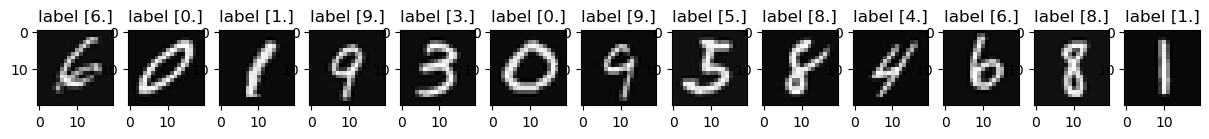

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

# Standarisation  des données

In [6]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)
#vu que le datast est grand pour mieux evaluer nos model on le diviser en train et test 
Xt, Xtt, Yt, Ytt = train_test_split(
      data, y, test_size = 0.30)

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [7]:
YY=np.zeros((Yt.shape[0], int(np.max(y))+1))
YY.shape

(3500, 10)

In [8]:
for i in range (YY.shape[0]):
    YY[i,int(Yt[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [9]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [10]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [11]:
input_layer_size  = 400
hidden_layer_size = 25   
num_labels = 10

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=2}^{401} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=2}^{26} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [12]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

In [13]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J = np.zeros((YY.shape[0],1))
    #cout avec le terme de regularisation ajouter
    J = (1 / y.shape[0]) * (np.sum(np.sum((-YY * np.log(a3)) - ((1 - YY) * np.log(1 - a3))))) + \
        (lambda_ / (2 * X.shape[0])) * (np.power(theta1[:, 1:], 2).sum() + np.power(theta2[:, 1:], 2).sum())

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [14]:
def NNCostFunction(X, YY, theta1, theta2, hidden_layer_size, lambda_ = 0):
    a1 = X # 5000x401
    z2 = X @ theta1.T # 5000x401 @ 401x25 = 5000x25
    a2 = np.column_stack((np.ones((z2.shape[0], 1)), Sigmoid(z2))) # 5000x26

    z3 = a2 @ theta2.T # 5000x26 @ 26x10 = 5000x10
    a3 = Sigmoid(z3) # 5000x10

    delta3 = a3 - YY # 5000x10

    delta2 = ((delta3 @ theta2) * a2 * (1 - a2))[:, 1:] # 5000x25 | il y a que 25 neurones, le dernier delta est celui du biais de la deuxième couche

    # Calcule du gradient entre la couche cacher et la couche  de sortie .
    #nos données on besoin d'avoir la meme dimension avant d'appliquer la multiplication 
    delta3_broadcast = np.broadcast_to(delta3[:, :, np.newaxis], (*delta3.shape, a2.shape[1]))
    a2_broadcasted = np.broadcast_to(a2[:, np.newaxis, :], (a2.shape[0], delta3.shape[1], a2.shape[1]))
    
    theta2_grad_unreg = delta3_broadcast * a2_broadcasted
    theta2_grad = theta2_grad_unreg.mean(axis=0)

    # Ajout du terme de regularization
    reg_term2 = (lambda_ / X.shape[0]) * np.column_stack((np.zeros((theta2.shape[0], 1)), theta2[:, 1:]))
    theta2_grad += reg_term2

    # Calcule du gradient entre  la couche d'entrer et la couche cacher  .
    #nos données on besoin d'avoir la meme dimension avant d'appliquer la multiplication 
    delta2_broadcast = np.broadcast_to(delta2[:, :, np.newaxis], (*delta2.shape, a1.shape[1]))
    a1_broadcasted = np.broadcast_to(a1[:, np.newaxis, :], (a1.shape[0], delta2.shape[1], a1.shape[1]))
    theta1_grad_unreg = delta2_broadcast * a1_broadcasted
    theta1_grad = theta1_grad_unreg.mean(axis=0)

    # Ajout du terme de regularization
    reg_term1 = (lambda_ / X.shape[0]) * np.column_stack((np.zeros((theta1.shape[0], 1)), theta1[:, 1:]))
    theta1_grad += reg_term1


    J = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_)
    
    return J, [theta1_grad, theta2_grad]

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



Vu qu'on veut calculer la précision du modele durant l'apprentissage on doit définit la fonction prédiction avant la descente du gradient

In [15]:
def predict(W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    h1_output = Sigmoid(X @ W1.T)
    
    intercept = np.ones((X.shape[0],1))
    h2_input = np.column_stack((intercept, h1_output))
    
    h2_output = Sigmoid(h2_input @ W2.T)
    
    y_pred = np.argmax(h2_output, axis=1)[..., np.newaxis]
    
    
    return y_pred

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [16]:
#Cette meme fonction fonction avec et sans régularisation 
#il suffit juste de metre lambda a 0 pour avoir un apprentissage sans regularisation
def gradientDescent(X, YY,y, theta, alpha, iterations, lambda_ = 0,early_stopping=False):
    costs, precisions = [], []
    epsilon = 1e-9
    for _ in range(iterations):
        cost, grad = NNCostFunction(X, YY, theta[0], theta[1], hidden_layer_size, lambda_)
        
        theta[0] = theta[0] - alpha * grad[0]
        theta[1] = theta[1] - alpha * grad[1]
        #calcule de la précision du modele en utilisant la partie test du dataset 
        y_pred=predict(theta[0],theta[1],Xtt)
        precision = np.mean(y==y_pred)*100
        
        precisions.append(precision)
        costs.append(cost)
        if early_stopping and i > 0 and (costs[-2] - costs[-1]) < epsilon: 
            break
        
    return theta, costs, precisions

In [17]:
iterations = 500
alpha = 1.5
#initialisation des thetas avec les valeurs données 
theta = [W1 ,W2]
theta, costs, precisions = gradientDescent(Xt, YY,Ytt, theta, alpha, iterations)

In [18]:
#fonction pour afficher les graphes du cout et de la précision 
def plot_cost_precision(costs, gradients):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("costs")
    plt.plot(range(len(costs)), costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.subplot(1, 2, 2)
    plt.title("precisions")
    plt.plot(range(len(precisions)), precisions)
    plt.xlabel('iterations')
    plt.ylabel('precision')

93.66666666666667


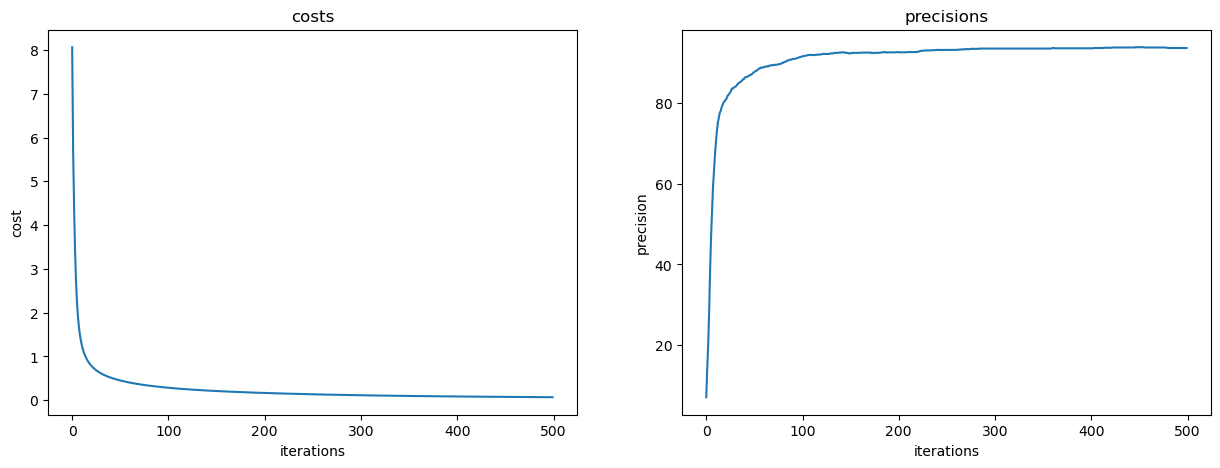

In [19]:
plot_cost_precision(costs, precisions)
print(precisions[-1])

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

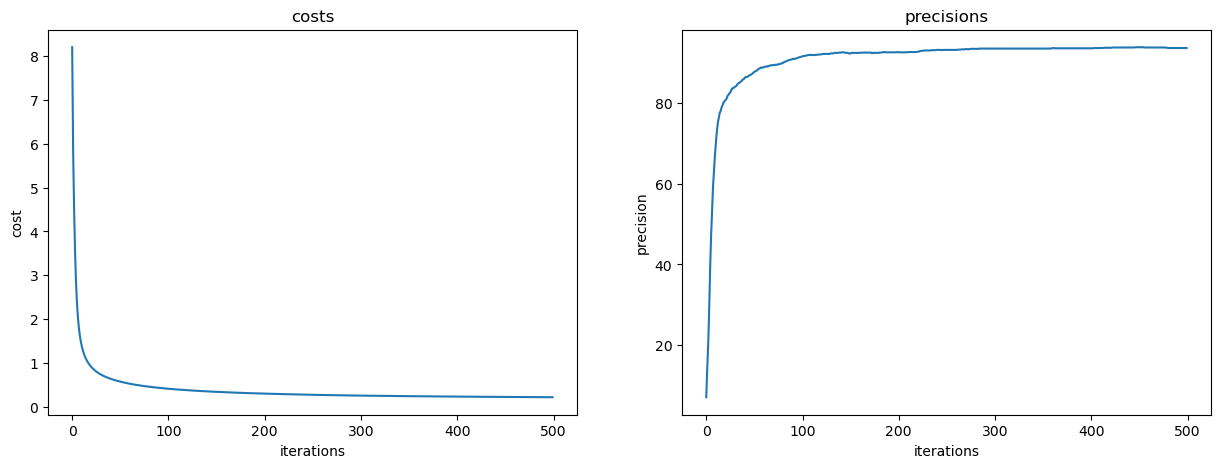

In [20]:
iterations = 500
alpha = 1.5
theta = [W1 ,W2]
thetareg, costsreg, precisionsreg = gradientDescent(Xt, YY,Ytt, theta, alpha, iterations,lambda_=1)
plot_cost_precision(costsreg, precisionsreg)

In [21]:
# affichage de la précision
print(precisionsreg[-1])

94.13333333333334


on retrouve qu'avec la regularisation on peux améliorer la precision de notre modele sur le dataset test ce qui est logique vu que le model avec regularisation est plus generalisable 

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [22]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
model.fit(Xt[:,1:], Yt.ravel())


MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [23]:
y_pred=model.predict(Xtt[:,1:])
precision = np.mean(Ytt.ravel()==y_pred)*100
precision

94.46666666666667

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

In [24]:
def visualize_weights(w1):
    plt.figure(figsize=(50, 20))
    for i in range(w1.shape[0]):
        plt.subplot(3, 13, i + 1)
        plt.imshow(np.reshape(w1[i][1:], (20, 20)))

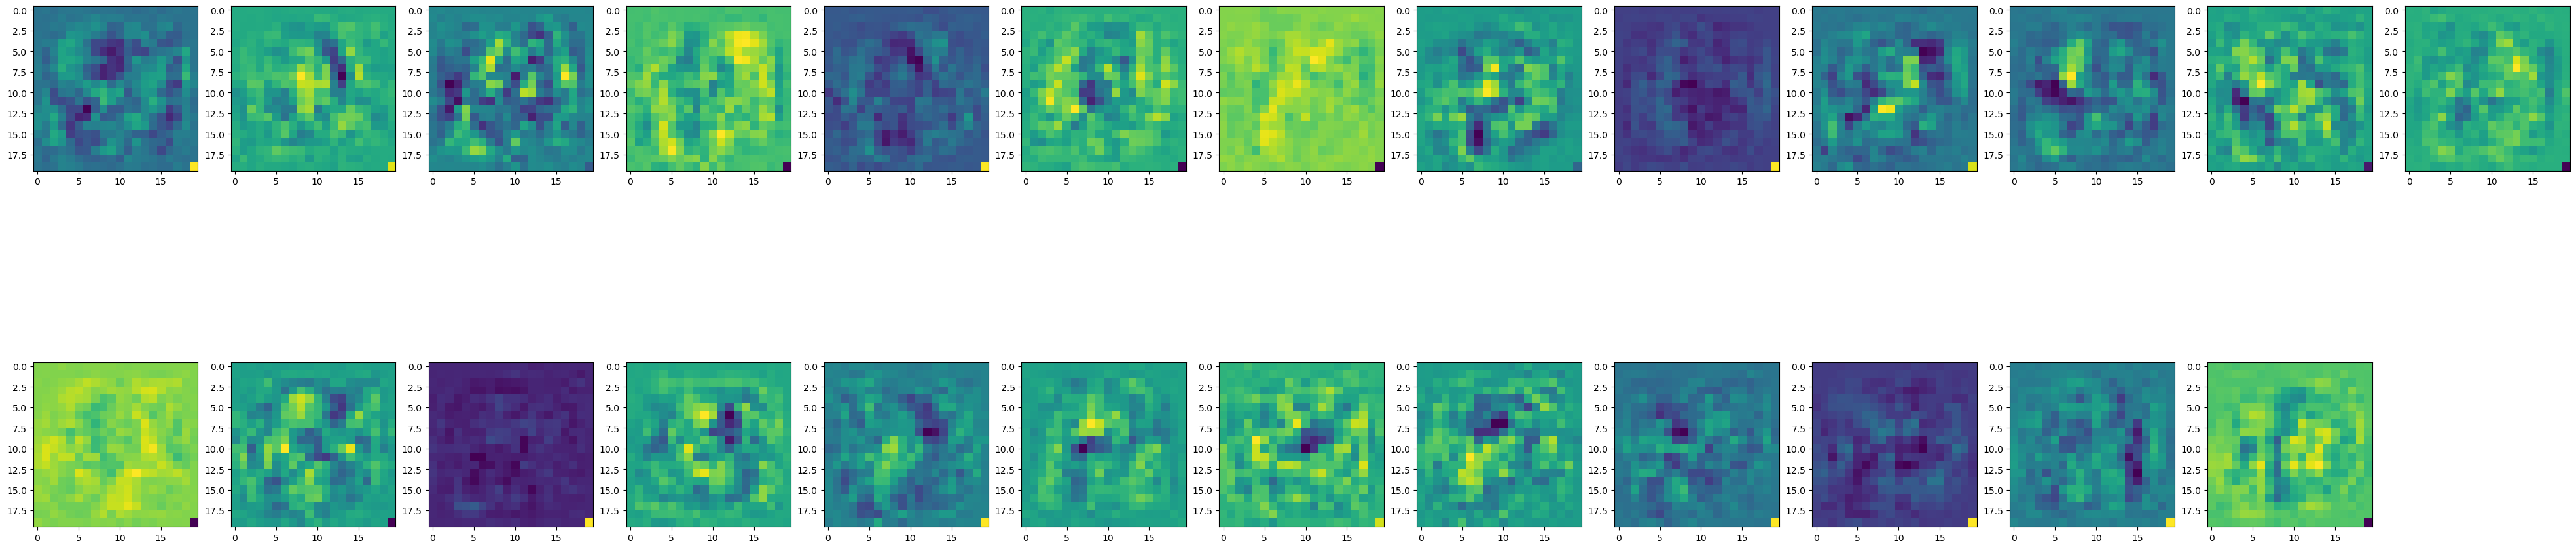

In [25]:
#affichage pour le model sans regularization
visualize_weights(theta[0])

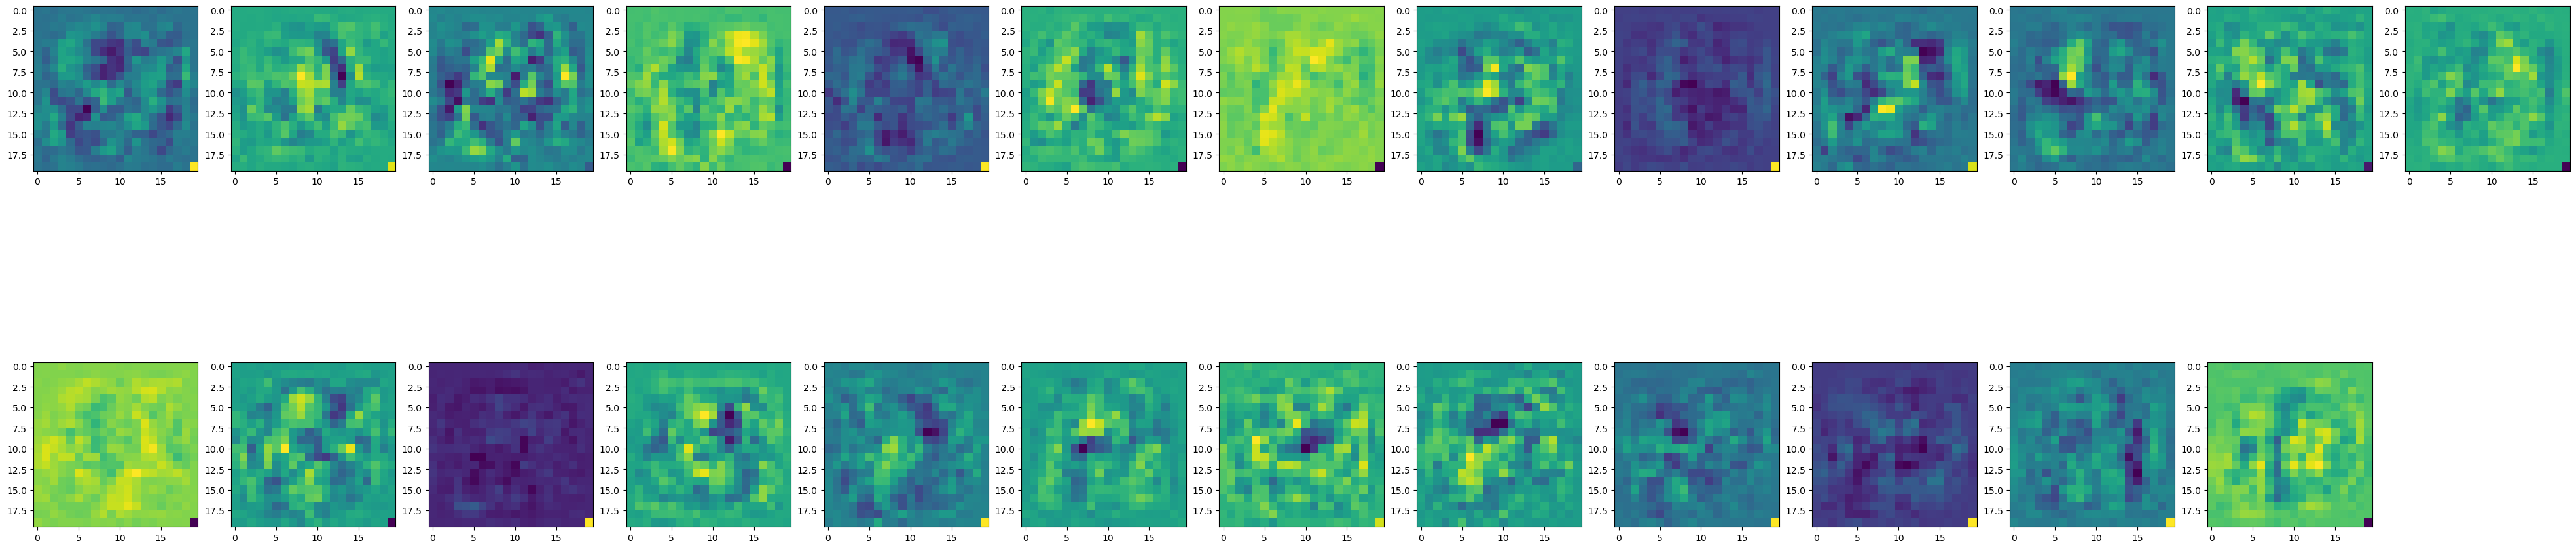

In [26]:
#affichage pour le model avec  regularization
visualize_weights(thetareg[0])

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

## Descente du gradients mini-batch 
vu que notre dataset est grand nous avons opter pour tester une version de la descente du gradients qui est le mini-batch cette version ne calcule pas le gradients pour touts le dataset et met a jour les theta comme la descente du gradient mais plutot devise le dataset en partie (mini-bach) et pour chaque mini batch calcule le gradient et met ajour les theta 

In [27]:
def miniBatchGradientDescent(X, Y, theta, alpha, iterations, batch_size, lambda_=0, early_stopping=False):
    costs, precisions = [], []
    epsilon = 1e-9
    m = X.shape[0]
    num_batches = m // batch_size
    
    for i in range(iterations):
        #pour chaque mini batch
        for j in range(num_batches):
            start_idx = j * batch_size
            end_idx = start_idx + batch_size
            
            X_batch = X[start_idx:end_idx]
            Y_batch = Y[start_idx:end_idx]
            
            cost, grad = NNCostFunction(X_batch, Y_batch, theta[0], theta[1], hidden_layer_size, lambda_)
            
            theta[0] = theta[0] - alpha * grad[0]
            theta[1] = theta[1] - alpha * grad[1]
            
        cost, _ = NNCostFunction(X, Y, theta[0], theta[1], hidden_layer_size, lambda_)
        y_pred = predict(theta[0], theta[1], Xtt)
        precision = np.mean(Ytt==y_pred)*100
        
        precisions.append(precision)
        costs.append(cost)
        if early_stopping and i > 0 and (costs[-2] - costs[-1]) < epsilon: 
            break
            
    return theta, costs, precisions


(3500, 10)


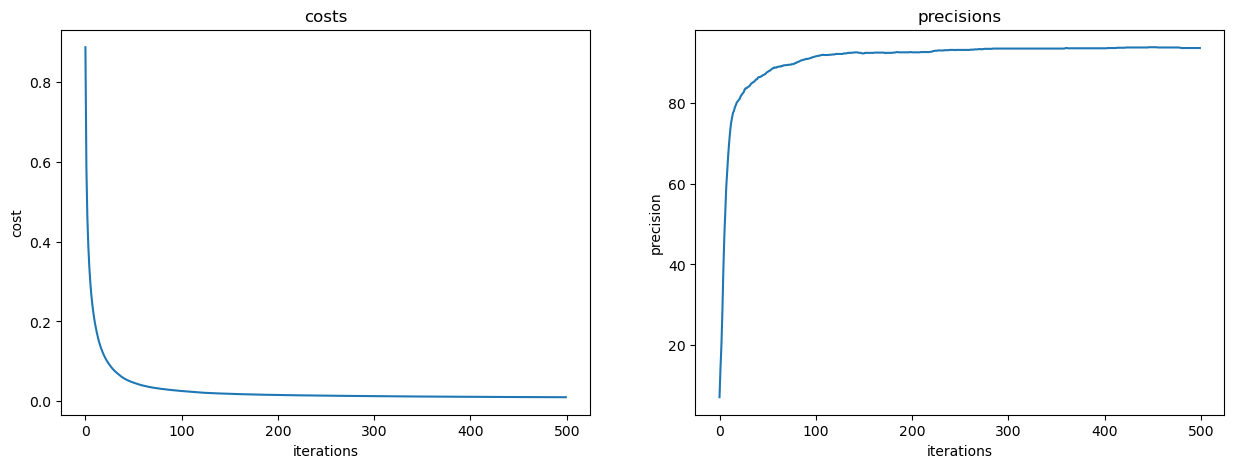

In [28]:
iterations = 500
alpha = 1.5
theta = [W1 ,W2]
print(YY.shape)
thetamini, costsmini, precisionsmini = miniBatchGradientDescent(Xt, YY, theta, alpha, iterations,200)
plot_cost_precision(costsmini, precisionsmini)

In [29]:
print(precisionsmini[-1])

94.19999999999999


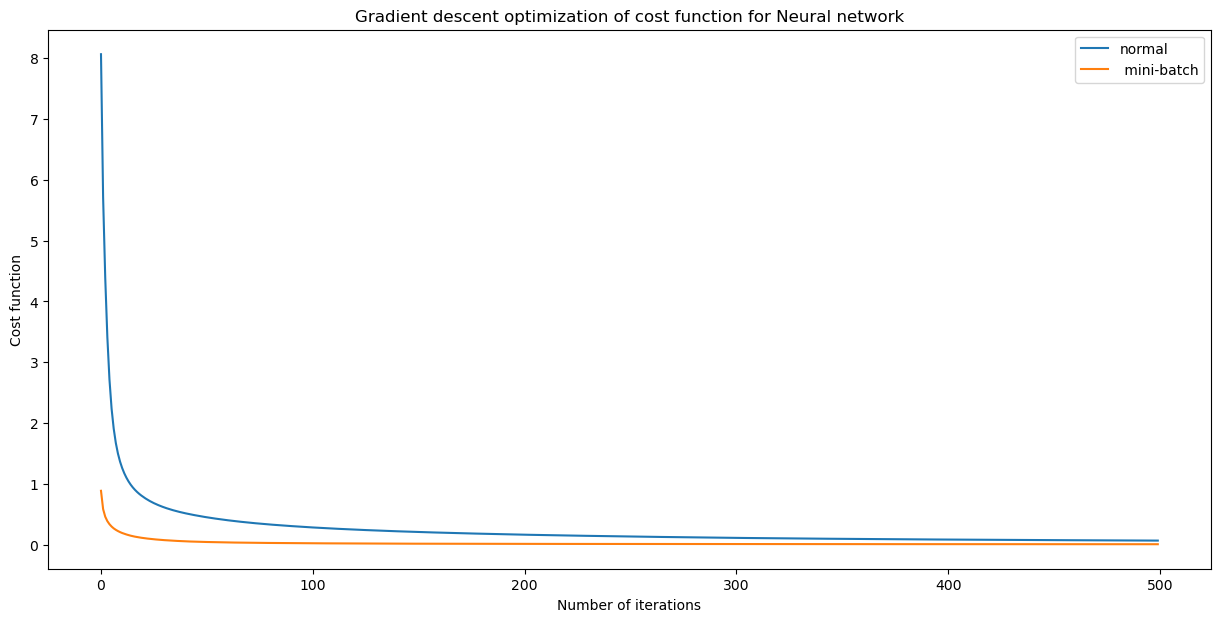

In [30]:
#graphe de comparaison 
plt.figure(figsize=(15, 7))
plt.plot(range(len(costs)), costs,label='normal')
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.plot(range(len(costsmini)),costsmini,label=' mini-batch')
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.legend()
plt.title("Gradient descent optimization of cost function for Neural network")
plt.show()

on remarque que l'utilisation du mini btach offre une meilleure convergence 

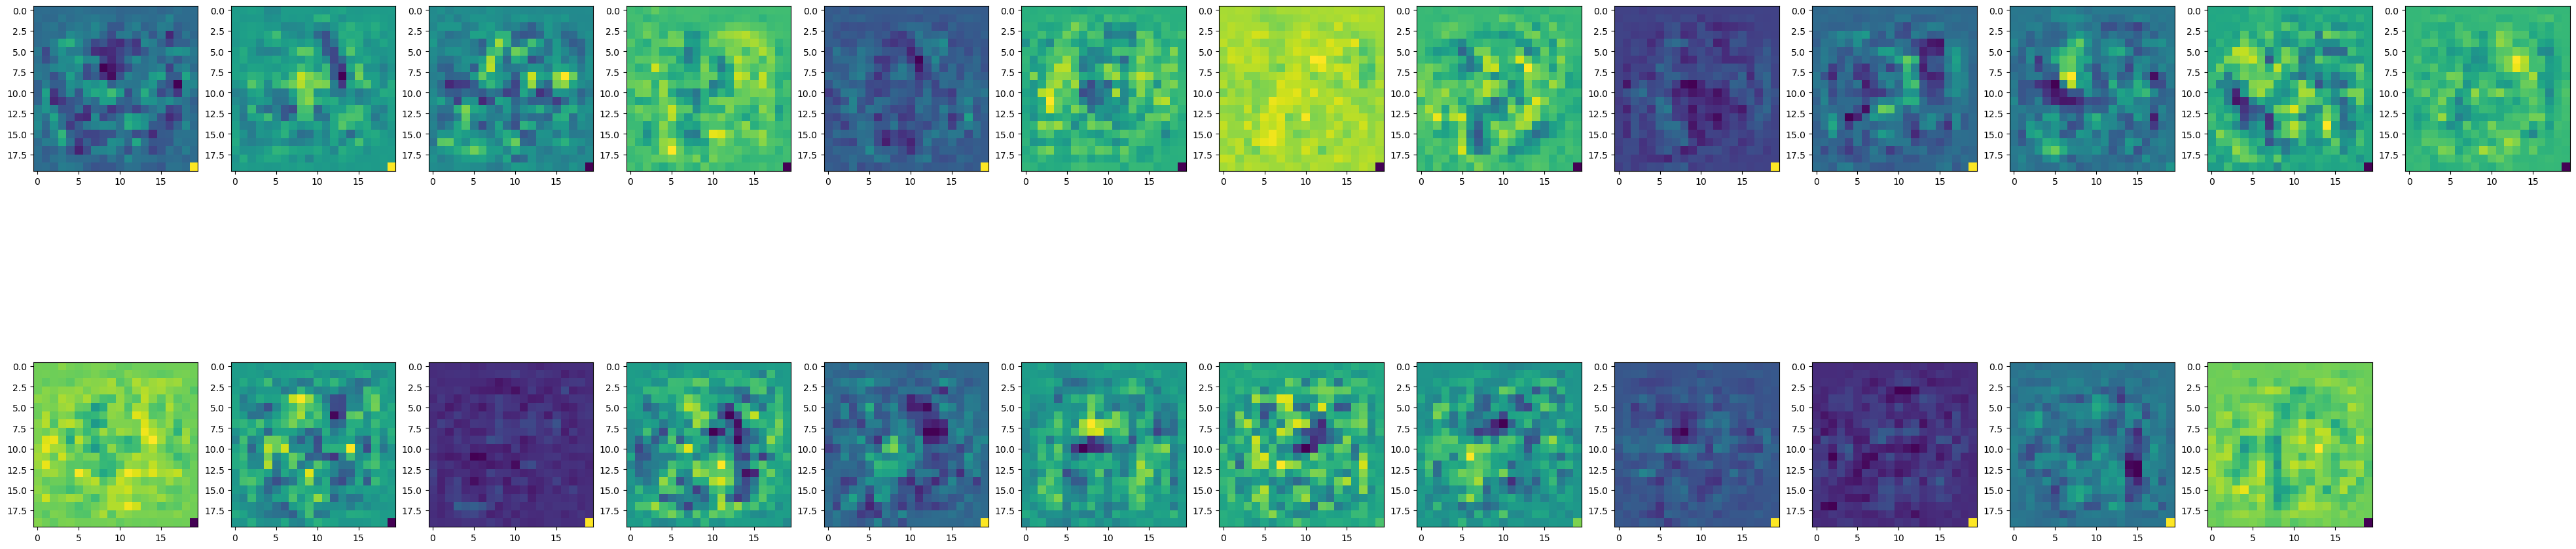

In [31]:
#affichage des poids 
visualize_weights(thetamini[0])

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [32]:
# bonne chance